In [1]:
#############################################################################################

##### 2-STAGE ESTIMATOR FOR LAO 3RD NFI CYCLE #####
##### DATA PROVIDED BY LAO Department of Forestry, Ministry of Agriculture and Forestry (DOF; https://nfms.maf.gov.la/)
##### DATA IS NOT PUBLICLY AVAILABLE

##### Code prepared by Neha Hunka, University of Maryland
##### Manuscript available at doi: 10.1088/1748-9326/ad0b60 (https://iopscience.iop.org/article/10.1088/1748-9326/ad0b60)
##### Supplementary documentation at https://content.cld.iop.org/journals/1748-9326/18/12/124042/revision2/erlad0b60supp1.pdf?Expires=1720847657&Signature=aV-X~Cs2M7LMHMaVrc8F16uaxib1w8vgRZWNBotBWJaxJ03dHp~I85GONti6QQ-7dgvgQXN4gusDhNj2AfNGX42FIp3l2WX0n~5kup0qcbe9jvNAp5Ce0n4uvvC~yHvUkp6UeuS6YuZiqPULthGILQwEz5w6hyo4ybY3vBxhMiqj-m5NfapyLaR9IgdGVQvOtdVIR5KSptzjZjuazHEHZRWMpRTj1DzqEUgUwNNpNrnV18~F8tjif88nFK8edK-bFyP-kamBfHItj0~9pztfVPmGikNMKwcM0bMYGTuQNd76IxCDUgzGfdYvrkq64o8wz3SDjiWJ1icmrAMA78yM6Q__&Key-Pair-Id=KL1D8TIY3N7T8

In [1]:
#############################################################################################
### INSTALL PACKAGES
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
### READ NFI DATA
DATA <- read.csv("/projects/my-private-bucket/Data/NFI_data/Laos/RCode_NFI3_TreePlots_Cstock_StrataArea_DesignStrata_UMD.csv")

#####  FEW NOTES ABOUT THE DATAFRAME "DATA" READ FROM THE CSV
## Ftype: Forest type identified by the team in the field at the sub-plot (or tree-plot) location.
## Assigned_Ftype:  Forest type assigned to the plot based on the Ftype of the sub-plots.
## Design_SSU_Ftype : Pre-sampling forest-type stratum for each SSU based on the country's forest strata map (extracted using QGIS)
## Design_PSU_Ftype : Pre-sampling forest-type stratum for each PSU based on forest strata of the anchor plot (here, I chose "sub_plotA" as the anchor plot, "sub_plotB" if A was not available...and so on)(extracted using QGIS).
## Design_PSU_StrataArea_MAX : The forest stratum that has the largest area (i.e. in m2) in each PSU (extracted using QGIS).

In [3]:
##### DATA FILTERS, IF NEEDED
# DATA <-  DATA[DATA$lc0 != "nf",] # Only plots in forest strata are considered
# DATA <-  DATA[DATA$CstockAGB != 0,] # Only plots with AGB > 0 are considered

##### CORRECTING THE RESULTS OF THE ALLOMETRIC MODEL 
## NOTE, when the ln-ln allometric model is applied, a correction factor is needed when the plot-level AGBD is derived AFTER back-transformation
## Two correction factors are provided below, but the allometric models must be checked and refit correctly. This script does not perform model refitting.
## A separate script is available for this step, if required. 

EF_correction_factor = 1.045282
DD_correction_factor = 1.035969
DATA$AGB_Mgha[DATA$Ftype == "EF"] = DATA$AGB_Mgha[DATA$Ftype == "EF"]*EF_correction_factor
DATA$AGB_Mgha[DATA$Ftype == "DD"] = DATA$AGB_Mgha[DATA$Ftype == "DD"]*DD_correction_factor
y_hij = DATA$AGB_Mgha # value of AGB in each subplot estimated by Lao NFI

In [ ]:
##### BEGIN ANALYSIS 
## It is important to note that for strata for which the stratification map has greater inaccuracies, 
## i.e. mismatches between field observations and map stratum classifications, the estimates of the 
## strata AGBD means will not correspond to a single forest type but rather to the mix of strata observed 
## by the field crews for plots assigned by the map to strata. For this reason, the estimates obtained in 
# this study differ from those used nationally by the DOF for each forest type, for example, for REDD+ assessments.

PSU_IDs <- unique(DATA$ID) #these are unique IDs of all PSUs
PSU_sampled <- as.data.frame(DATA %>% group_by(ID) %>% summarize (Design_PSU_Ftype=names(which.max(table(Design_PSU_Ftype))))) # Associate each PSU with a single stratum, based on the "Design_PSU_Ftype" column in DATA
UNQ_STRATA = c("EF", "MDF",  "DD",  "CF", "MCB")

A_hij <- DATA[,29:33] # Columns EF_Area_m2, MDF_Area_m2, DD_Area_m2, CF_Area_m2, MCB_Area_m2, which is the area of each strata in each 3 km x 3 km PSU
A_hij["ID"] = DATA$ID
A_hij["Design_PSU_Ftype"] = DATA$Design_PSU_Ftype
# A_hij[,1][A_hij$Design_PSU_Ftype != "EF"] = 0
# A_hij[,2][A_hij$Design_PSU_Ftype != "MDF"] = 0
# A_hij[,3][A_hij$Design_PSU_Ftype != "DD"] = 0
# A_hij[,4][A_hij$Design_PSU_Ftype != "CF"] = 0
# A_hij[,5][A_hij$Design_PSU_Ftype != "MCB"] = 0
# A_hij[A_hij == 0] = NA

A_hi = aggregate(A_hij, list(A_hij$ID), FUN=mean, na.rm=TRUE) # Simply collapses rows, so we have the area of each strata in each 3 km x 3 km PSU occuring in just one row 
# Total_area =aggregate(DATA$TOTAL_AREA, list(DATA$ID), FUN=mean, na.rm=TRUE) #Total area of all strata within the subplots
a = 3000 * 3000 #1256.64 #in units of m2, area of each 20-m radius plot

M_hi = A_hi/a # M_hi is the total number of SSU-size units within the i_th PSU within the h_th stratum
M_hi["ID"] = A_hi$ID
colnames(M_hi) = c("Random","EF_M_hi","MDF_M_hi","DD_M_hi","CF_M_hi","MCB_M_hi","ID")

In [5]:
M_hi

Random,EF_M_hi,MDF_M_hi,DD_M_hi,CF_M_hi,MCB_M_hi,ID,NA
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.111111e-07,0.0000,0.3256,0,0.2072,0.0000,1,NA
2.222222e-07,0.0000,0.0190,0,0.2154,0.0000,2,NA
3.333333e-07,0.0000,0.1169,0,0.2355,0.2230,3,NA
4.444444e-07,0.0000,0.2384,0,0.4936,0.0113,4,NA
5.555556e-07,0.0000,0.3130,0,0.5640,0.0188,5,NA
6.666667e-07,0.0000,0.3765,0,0.3788,0.0110,6,NA
7.777778e-07,0.0000,0.1228,0,0.4133,0.0276,7,NA
8.888889e-07,0.0000,0.0504,0,0.5107,0.0137,8,NA
1.000000e-06,0.0000,0.0767,0,0.4762,0.0023,9,NA


In [6]:
#############################################################################################
# Now, we produce m_hi, that is how many of each strata were in the SSUs contained in each PSU
# For this, we create empty columns in an empty dataframe "DATA_PSU" and populate it with the number of strata

DATA_PSU <- data.frame(PSU_IDs) # Create a new PSU dataframe
for (h in UNQ_STRATA){ #for each stratum in the country
  newcol_name <- paste0(h,"_m_hi") #Create column names
  DATA_PSU[newcol_name] <- NA # Create empty columns
}
counter_PSU = 0 #set a counter for the following for loop

for (i in PSU_IDs) { #for each PSU
  counter_PSU = counter_PSU + 1
  counter_STRATA = 1
  for (h in UNQ_STRATA){ #for each stratum in the country
    counter_STRATA = counter_STRATA + 1
    DATA_subset = DATA[DATA$ID == i,] #subset data for one PSU at a time
    DATA_PSU[counter_PSU,counter_STRATA] = nrow(DATA_subset[DATA_subset$Design_PSU_Ftype == h,]) #find the count of SSUs in subset data
  }
}
DATA_PSU['TOTAL_n_SSU'] = rowSums(DATA_PSU[,2:ncol(DATA_PSU)])
NCOL <- ncol(DATA_PSU)
### The dataset DATA_PSU contains values of "m_hi", which is the number of SSUs within the ith PSU within the hth stratum

In [7]:
DATA_PSU

PSU_IDs,EF_m_hi,MDF_m_hi,DD_m_hi,CF_m_hi,MCB_m_hi,TOTAL_n_SSU
<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,0,0,0,4,0,4
2,0,0,0,4,0,4
3,0,0,0,4,0,4
4,0,0,0,4,0,4
5,0,0,0,4,0,4
6,0,0,0,4,0,4
7,0,0,0,4,0,4
8,0,0,0,4,0,4
9,0,0,0,4,0,4


In [8]:
### Now, we produce y_bar_hi, which is the mean PSU AGBD, for m_hi samples
### We do this in two steps. First, we calculate the sum of all AGBDs in the relevant SSUs and then divide by m_hi. 

### STEP 1: Sums y_hij from j=1 until j=m_hi (equation 12), but without yet dividing by m_hi 
for (h in UNQ_STRATA){ #for each stratum in the country
  Design_PSU_Ftype_name <- paste0(h,"_y_sum_hi") #Create column names
  DATA_PSU[Design_PSU_Ftype_name] <- 0 # Create empty columns
}

counter_PSU = 0 #set a counter for the following for loop
for (i in PSU_IDs) { #for each PSU
  counter_PSU = counter_PSU + 1
  counter_STRATA = NCOL
  for (h in UNQ_STRATA){ #for each stratum in the country
    counter_STRATA = counter_STRATA + 1
    DATA_subset = DATA[DATA$ID == i,]
    DATA_PSU[counter_PSU,counter_STRATA] = sum(DATA_subset[DATA_subset$Design_PSU_Ftype == h,]$AGB_Mgha,na.rm=TRUE) #This is step 1, just adding all the AGBDs per stratum per PSU. It has no physical meaning at this stage. 
  }
}

# M_hi = M_hi[DATA_PSU$TOTAL_n_SSU == 4,]
# DATA_PSU = DATA_PSU[DATA_PSU$TOTAL_n_SSU == 4,]

DATA_PSU <- cbind(DATA_PSU,M_hi[2:6],PSU_sampled)
DATA_PSU[DATA_PSU==0] = NA

DATA_PSU

PSU_IDs,EF_m_hi,MDF_m_hi,DD_m_hi,CF_m_hi,MCB_m_hi,TOTAL_n_SSU,EF_y_sum_hi,MDF_y_sum_hi,DD_y_sum_hi,CF_y_sum_hi,MCB_y_sum_hi,EF_M_hi,MDF_M_hi,DD_M_hi,CF_M_hi,MCB_M_hi,ID,Design_PSU_Ftype
<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
1,NA,NA,NA,4,NA,4,NA,NA,NA,722.4723,NA,NA,0.3256,NA,0.2072,NA,1,CF
2,NA,NA,NA,4,NA,4,NA,NA,NA,267.2289,NA,NA,0.0190,NA,0.2154,NA,2,CF
3,NA,NA,NA,4,NA,4,NA,NA,NA,397.2155,NA,NA,0.1169,NA,0.2355,0.2230,3,CF
4,NA,NA,NA,4,NA,4,NA,NA,NA,843.2634,NA,NA,0.2384,NA,0.4936,0.0113,4,CF
5,NA,NA,NA,4,NA,4,NA,NA,NA,702.6085,NA,NA,0.3130,NA,0.5640,0.0188,5,CF
6,NA,NA,NA,4,NA,4,NA,NA,NA,602.8639,NA,NA,0.3765,NA,0.3788,0.0110,6,CF
7,NA,NA,NA,4,NA,4,NA,NA,NA,307.6249,NA,NA,0.1228,NA,0.4133,0.0276,7,CF
8,NA,NA,NA,4,NA,4,NA,NA,NA,326.9577,NA,NA,0.0504,NA,0.5107,0.0137,8,CF
9,NA,NA,NA,4,NA,4,NA,NA,NA,333.0189,NA,NA,0.0767,NA,0.4762,0.0023,9,CF


In [9]:
### STEP 2: Divides the sums of y_hij from j=1 until j=m_hi by m_hi(equation 12) 

y_bar_hi = DATA_PSU[8:12]/DATA_PSU[2:6]
colnames(y_bar_hi) = c("EF_y_bar_hi","MDF_y_bar_hi","DD_y_bar_hi","CF_y_bar_hi","MCB_y_bar_hi")
DATA_PSU <- cbind(DATA_PSU,y_bar_hi)

DATA_PSU[DATA_PSU$PSU_IDs == 479,]

,PSU_IDs,EF_m_hi,MDF_m_hi,DD_m_hi,CF_m_hi,MCB_m_hi,TOTAL_n_SSU,EF_y_sum_hi,MDF_y_sum_hi,DD_y_sum_hi,⋯,DD_M_hi,CF_M_hi,MCB_M_hi,ID,Design_PSU_Ftype,EF_y_bar_hi,MDF_y_bar_hi,DD_y_bar_hi,CF_y_bar_hi,MCB_y_bar_hi
,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
343,479,NA,NA,NA,4,NA,4,NA,NA,NA,⋯,NA,0.1976,0.009,479,CF,NA,NA,NA,106.3143,NA


In [17]:
## The step below would be equivalent to a simple expansion estimate
## We obtain it just to see what it looks like 
colMeans(y_bar_hi,na.rm=TRUE)

EF_y_bar_hi MDF_y_bar_hi  DD_y_bar_hi  CF_y_bar_hi MCB_y_bar_hi 
   211.42727    132.08629     92.64536    136.05539    176.92870

In [12]:
### Add information on Nh, which is the total possible PSUs per stratum. It is calculated on QGIS. 
DATA_PSU["Nh_EF"] = 4862 # This the total number of 3 km x 3 km PSUs could potentially have existed in the stratum EF in Laos
DATA_PSU["Nh_MDF"] = 18455 # This the total number of 3 km x 3 km PSUs could potentially have existed in the stratum MDF in Laos
DATA_PSU["Nh_DD"] = 2124 # This the total number of 3 km x 3 km PSUs could potentially have existed in the stratum DD in Laos
DATA_PSU["Nh_CF"] = 306 # This the total number of 3 km x 3 km PSUs could potentially have existed in the stratum CF in Laos
DATA_PSU["Nh_MCB"] = 245 # This the total number of 3 km x 3 km PSUs could potentially have existed in the stratum MCB in Laos

### Add information on nh, which is the number of PSUs selected for the sample in stratum h
counter_STRATA = 0
for (h in UNQ_STRATA){ #for each stratum in the country
  counter_STRATA = counter_STRATA + 1
  DATA_PSU_h <- DATA_PSU[DATA_PSU$Design_PSU_Ftype == h,]
  nh_name <- paste0("nh_",h) #Create column names
  DATA_PSU[nh_name] <- nrow(DATA_PSU_h) 
}

DATA_PSU[DATA_PSU$PSU_IDs == 479,]

,PSU_IDs,EF_m_hi,MDF_m_hi,DD_m_hi,CF_m_hi,MCB_m_hi,TOTAL_n_SSU,EF_y_sum_hi,MDF_y_sum_hi,DD_y_sum_hi,⋯,Nh_EF,Nh_MDF,Nh_DD,Nh_CF,Nh_MCB,nh_EF,nh_MDF,nh_DD,nh_CF,nh_MCB
,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>
343,479,NA,NA,NA,4,NA,4,NA,NA,NA,⋯,4862,18455,2124,306,245,141,52,73,53,40


In [13]:
### Checking if weights as applied in Lohr et al. work better
w_his = (DATA_PSU[,25:29] * DATA_PSU[,13:17]) /(DATA_PSU[,30:34] * DATA_PSU[,2:6])
# DATA_PSU = cbind(DATA_PSU,w_his)

In [14]:
COLNAMES <- (as.data.frame(colnames(DATA_PSU)))
COLNAMES$NUMBER <- seq.int(nrow(COLNAMES))
COLNAMES

colnames(DATA_PSU),NUMBER
<chr>,<int>
PSU_IDs,1
EF_m_hi,2
MDF_m_hi,3
DD_m_hi,4
CF_m_hi,5
MCB_m_hi,6
TOTAL_n_SSU,7
EF_y_sum_hi,8
MDF_y_sum_hi,9


In [15]:
counter_STRATA = 0
mu_h_saved <- c(0,0,0,0,0)
for (h in UNQ_STRATA){ 
  counter_STRATA = counter_STRATA + 1
  DATA_PSU_h <- DATA_PSU[DATA_PSU$Design_PSU_Ftype == h,]
  print(nrow(DATA_PSU_h))
  print(paste0("Simple expansion mean of strata ", h, "    ", as.character(colMeans(DATA_PSU_h[,20:24],na.rm=TRUE)[counter_STRATA])))
  mu_h <- (colSums((DATA_PSU_h[,20:24]) * (DATA_PSU_h[,13:17]),na.rm=TRUE)/colSums((DATA_PSU_h[,13:17]),na.rm=TRUE))
  print(paste0("Two-stage mean of strata ",h, "    ", as.character(mu_h[counter_STRATA])))
  mu_h_saved[counter_STRATA] <- mu_h[counter_STRATA]
}

[1] 141
[1] "Simple expansion mean of strata EF    211.427267777944"
[1] "Two-stage mean of strata EF    217.608100733406"
[1] 52
[1] "Simple expansion mean of strata MDF    132.086287579342"
[1] "Two-stage mean of strata MDF    126.238188541627"
[1] 73
[1] "Simple expansion mean of strata DD    92.6453646040159"
[1] "Two-stage mean of strata DD    91.3520067557669"
[1] 53
[1] "Simple expansion mean of strata CF    136.05538924296"
[1] "Two-stage mean of strata CF    134.701048742393"
[1] 40
[1] "Simple expansion mean of strata MCB    176.928701964719"
[1] "Two-stage mean of strata MCB    194.474624038209"


,M_h_bar,n_h,N_h,mu_h
,<dbl>,<dbl>,<dbl>,<dbl>
EF_M_hi,0.5216552,141,4862,217.60810
MDF_M_hi,0.2714491,52,18455,126.23819
DD_M_hi,0.3776907,73,2124,91.35201
CF_M_hi,0.2696124,53,306,134.70105
MCB_M_hi,0.2466721,40,245,194.47462


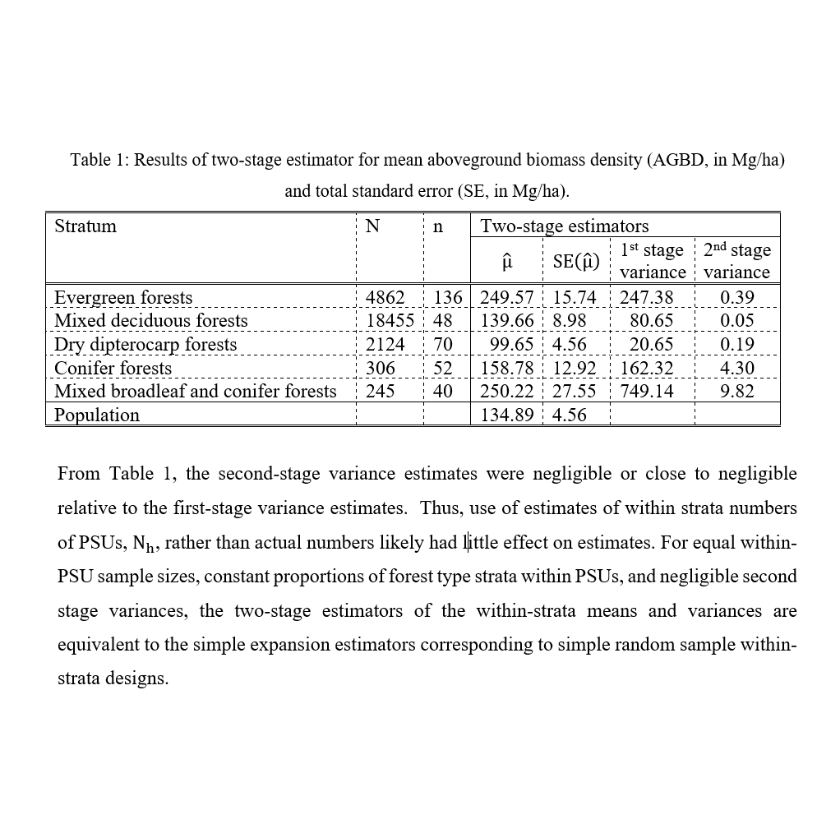

In [16]:
M_h_bar = colMeans(DATA_PSU[,13:17], na.rm=TRUE)
n_h = colMeans(DATA_PSU[,30:34], na.rm=TRUE)
N_h = colMeans(DATA_PSU[,25:29], na.rm=TRUE)
Stratum_TABLE <- cbind(as.data.frame(M_h_bar),as.data.frame(n_h),as.data.frame(N_h),mu_h_saved)
colnames(Stratum_TABLE) = c('M_h_bar','n_h','N_h','mu_h')
Stratum_TABLE

library(png)
library(grid)
file_path <- "/projects/my-private-bucket/Data/NFI_data/Laos/Laos_summary.PNG"
img <- readPNG(file_path)
grid.raster(img)

,M_h_bar,n_h,N_h,mu_h
,<dbl>,<dbl>,<dbl>,<dbl>
EF_M_hi,0.5216552,141,4862,217.81532
MDF_M_hi,0.2714491,52,18455,126.39158
DD_M_hi,0.3776907,73,2124,91.38068
CF_M_hi,0.2696124,53,306,134.92119
MCB_M_hi,0.2466721,40,245,194.19001


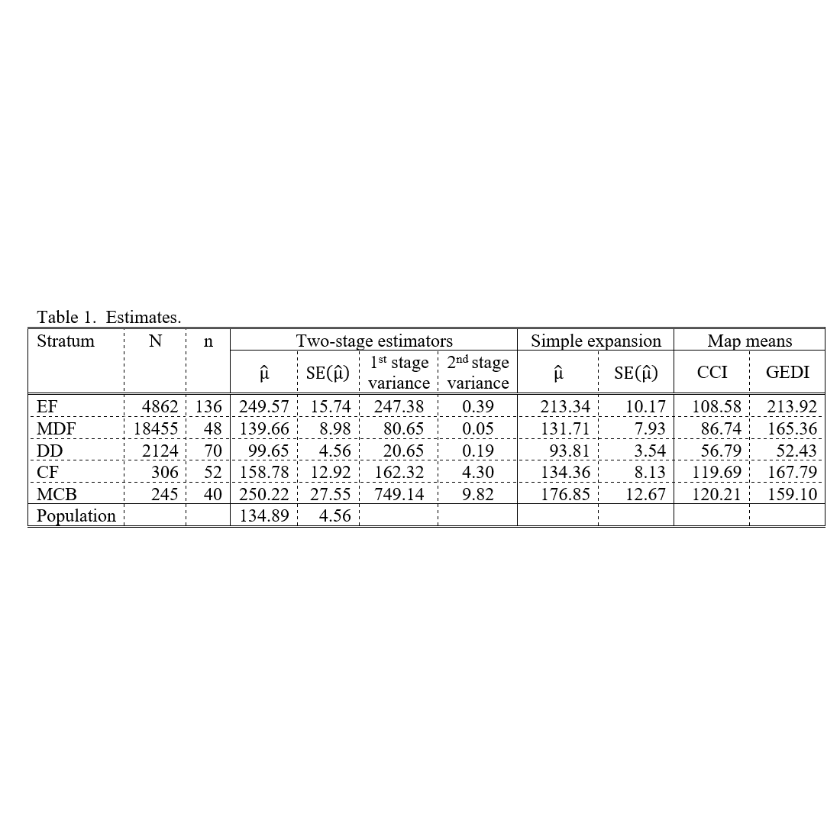

In [17]:
Stratum_TABLE

file_path <- "/projects/my-private-bucket/Data/NFI_data/Laos/Laos_summary_original.PNG"
img2 <- readPNG(file_path)
grid.raster(img2)

In [18]:
########### Now we move to calculating the 2-stage variance ###########

## First, we estimate M_h_bar (equation 14) 
Stratum_TABLE['s_h'] = NA
Stratum_TABLE['VAR_h'] = NA

# ## Second, we estimate s_h_square (equation 15) 
Stratum_TABLE$s_h[1] <- sum((DATA_PSU[,20] - mu_h_saved[1])^2,na.rm=TRUE)/(n_h[1]*(n_h[1]-1))
Stratum_TABLE$s_h[2] <- sum((DATA_PSU[,21] - mu_h_saved[2])^2,na.rm=TRUE)/(n_h[2]*(n_h[2]-1))
Stratum_TABLE$s_h[3] <- sum((DATA_PSU[,22] - mu_h_saved[3])^2,na.rm=TRUE)/(n_h[3]*(n_h[3]-1))
Stratum_TABLE$s_h[4] <- sum((DATA_PSU[,23] - mu_h_saved[4])^2,na.rm=TRUE)/(n_h[4]*(n_h[4]-1))
Stratum_TABLE$s_h[5] <- sum((DATA_PSU[,24] - mu_h_saved[5])^2,na.rm=TRUE)/(n_h[5]*(n_h[5]-1))

Stratum_TABLE

,M_h_bar,n_h,N_h,mu_h,s_h,VAR_h
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
EF_M_hi,0.5216552,141,4862,217.81532,102.87648,NA
MDF_M_hi,0.2714491,52,18455,126.39158,105.63961,NA
DD_M_hi,0.3776907,73,2124,91.38068,12.47030,NA
CF_M_hi,0.2696124,53,306,134.92119,65.67581,NA
MCB_M_hi,0.2466721,40,245,194.19001,186.14652,NA
